# Stochastic processes course 2018/2019-2 @ ELTE
# Assignment 7: Ising model simulation with Monte Carlo method
## 03.30.2019

# Ising model simulation on 1D lattice


Characteristic parameters of the system (for me):


$$
\beta J = \frac{J}{k_{B} T} = \left\{ 0.12,\ 0.24,\ 0.75,\ 1.60 \right\} \quad - \quad \text{Pál Balázs}
$$

In [100]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import os
import random
import seaborn as sns
from matplotlib.patches import Circle
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

sns.set_style(style='whitegrid')

image_format = 'pdf'
image_dpi = 150

## Characteristic parameters of the system

In [351]:
# Boltzmann constant
k_B = 1.380648e-23

# Number of spins, situated on the 1D lattice
N_spin_1D = 100

# Number of spins in a row at the 2D case
N_spin_2D = 40

# Arbitrary J
J = 1e-21

# Scale factor for the microscopic system
# beta = 1/(k_B * T)
beta_1 = 0.12 / (J)
print('At first case T = {0} K'.format(1 / (beta_1 * k_B)))
beta_2 = 0.24 / (J)
print('At second case T = {0} K'.format(1 / (beta_2 * k_B)))
beta_3 = 0.75 / (J)
print('At third case T = {0} K'.format(1 / (beta_3 * k_B)))
beta_4 = 1.60 / (J)
print('At fourth case T = {0} K'.format(1 / (beta_4 * k_B)))


betas = {'1': beta_1,
         '2': beta_2,
         '3': beta_3,
         '4': beta_4
        }

At first case T = 603.5813135088258 K
At second case T = 301.7906567544129 K
At third case T = 96.57301016141213 K
At fourth case T = 45.26859851316193 K


## 1.: Randomly choose directions for starting position of the spins

In [265]:
def choose_sign():
    return -1 if random.random() < 0.5 else 1

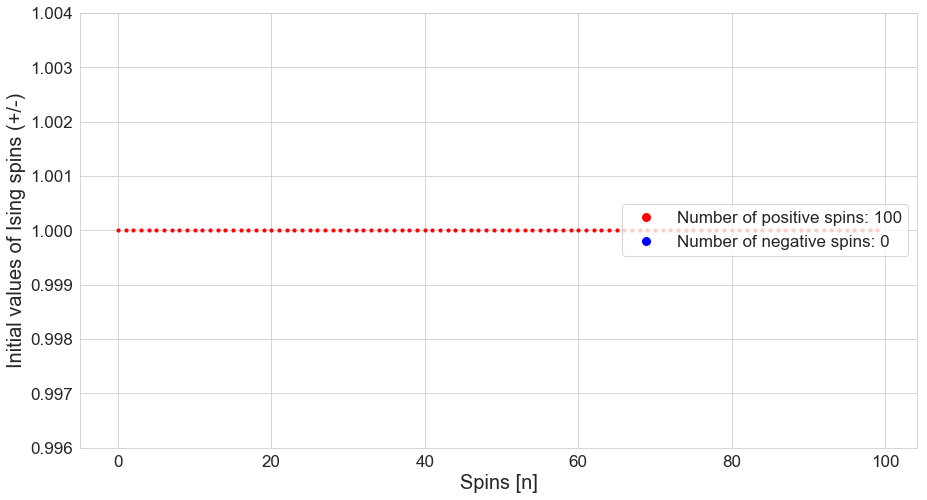

In [305]:
# The current positions of the spins
#Spins_1D = np.array([choose_sign() for i in range(0, N_spin)])
Spins_1D = np.ones((N_spin_1D))
Spins_positive_1D = Spins_1D[Spins_1D>0]
Spins_negative_1D = Spins_1D[Spins_1D<0]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,8))

scattersize = 10
axislabelsize = 20
axisticksize = 17
legendsize = 17

count = 0
for i in range(0, N_spin_1D):
    
    if(Spins_1D[i] > 0):
        axes.scatter(i, Spins_1D[i], color='red', s=scattersize)
    
    elif(Spins_1D[i] < 0):
        axes.scatter(i, Spins_1D[i], color='blue', s=scattersize)

axes.set_xlabel('Spins [n]', fontsize=axislabelsize)
axes.set_ylabel('Initial values of Ising spins (+/-)', fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)

legend_elements = [Line2D([0], [0], marker='o', color='white',markerfacecolor='red',
                          markersize=10, label='Number of positive spins: {0}'.format(len(Spins_positive_1D))),
                   Line2D([0], [0], marker='o', color='white', markerfacecolor='blue',
                          markersize=10, label='Number of negative spins: {0}'.format(len(Spins_negative_1D)))]

axes.legend(handles=legend_elements , loc='center right', fontsize=legendsize)

plt.show()

## 2.: $E_{tot.}$ energy of the current state

In [306]:
def E(Spins):
    E = 0
    
    for i in range(0, N_spin_1D-2):
        E += Spins[i] * Spins[i+1]
    
    return E * J

## 3.: Step with the simulation

In [307]:
def simulation_step_1D(beta, steps, Spins):

    # Chronologies for reached energy levels' indeces and actual energies in order
    spin_changes_chronology = np.zeros((steps+1, N_spin_1D), dtype='int')
    energy_chronology = np.zeros((steps+1))
    
    # Starting position on X axis
    energy_chronology[0] = E(Spins=Spins)

    for current_step in range(0, steps):
        # Choose a random Ising spin from the pool at the start of every step
        choosen_spin_index = np.random.choice([i for i in range(0, N_spin_1D)])
        
        # Rotate it to check the energy difference
        New_Spins = Spins
        New_Spins[choosen_spin_index] *= -1

        # Calculate energy difference between the jump's origin and end points
        E_1 = E(Spins=Spins)

        E_2 = E(Spins=New_Spins)
        
        delta_E = E_2 - E_1

        # Update chronology of reached energies indeces
        # If delta_E <= 0, then execute the flip
        if(delta_E < 0):
            spin_changes_chronology[current_step+1] = New_Spins
            Spins = New_Spins
            # Update chronology of actual reached energy levels
            energy_chronology[current_step+1] = E_2
            
        if(delta_E == 0):
            if(random.random() < 0.5):
                spin_changes_chronology[current_step+1] = New_Spins
                Spins = New_Spins
                # Update chronology of actual reached energy levels
                energy_chronology[current_step+1] = E_2
                
            else:
                spin_changes_chronology[current_step+1] = Spins
                # Update chronology of actual reached energy levels
                energy_chronology[current_step+1] = E_1

        # If delta_E > 0, choose a random number X, between 0 and 1
        # If X < e^(-beta * delta_E), then execute the spin flip
        # If not, then leave the spins' state untouched and continue with the next step
        else:
            if(random.random() < np.exp(- beta * delta_E)):
                spin_changes_chronology[current_step+1] = New_Spins
                Spins = New_Spins
                # Update chronology of actual reached energy levels
                energy_chronology[current_step+1] = E_2
                
            else:
                spin_changes_chronology[current_step+1] = Spins
                # Update chronology of actual reached energy levels
                energy_chronology[current_step+1] = E_1

    return spin_changes_chronology, energy_chronology, Spins

## Run the simulation with initial conditions

In [308]:
steps_1D = 1000

# Dicts for storing the energy levels' indeces and actual energies for various betas
spin_changes_chronology_1D = {}
energy_chronology_1D = {}
Spins_1D_dict = {}

# Run the simulation
for i in range(0,len(betas)):
    (spin_changes_chronology_1D[str(i+1)],
    energy_chronology_1D[str(i+1)],
    Spins_1D_dict[str(i+1)]) = simulation_step_1D(beta=betas[str(i+1)],
                                                  steps=steps_1D,
                                                  Spins=Spins_1D.copy())

step_indeces_1D = np.asarray([i for i in range(0,steps+1)])

## Final spin-state

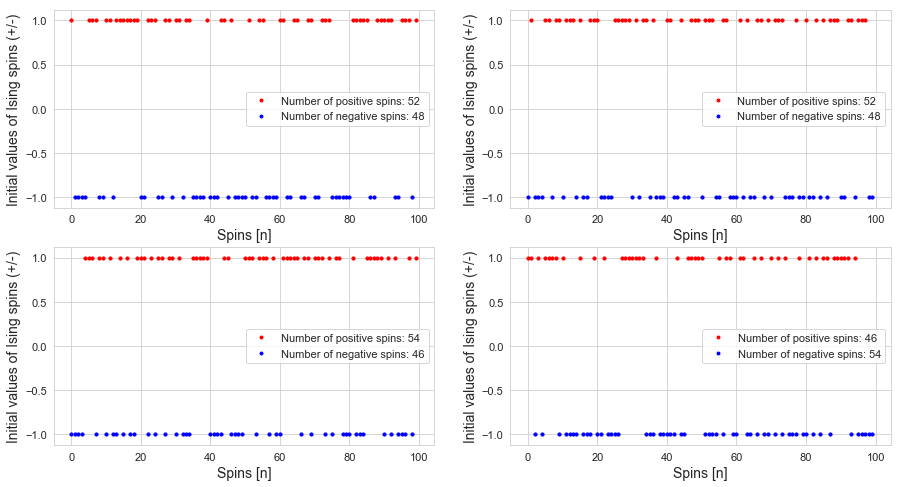

In [309]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,8))

scattersize = 10
axislabelsize = 14
axisticksize = 11
legendsize = 11

count = 0
for j in range(0, nrows):
    for k in range(0, ncols):
        # The current positions of the spins
        Spins_positive_1D = Spins_1D_dict[str(j*ncols + k + 1)][Spins_1D_dict[str(j*ncols + k + 1)]>0]
        Spins_negative_1D = Spins_1D_dict[str(j*ncols + k + 1)][Spins_1D_dict[str(j*ncols + k + 1)]<0]

        for i in range(0, N_spin_1D):
            if(Spins_1D_dict[str(j*ncols + k + 1)][i] > 0):
                axes[j][k].scatter(i, Spins_1D_dict[str(j*ncols + k + 1)][i], color='red', s=scattersize)

            elif(Spins_1D_dict[str(j*ncols + k + 1)][i] < 0):
                axes[j][k].scatter(i, Spins_1D_dict[str(j*ncols + k + 1)][i], color='blue', s=scattersize)

        axes[j][k].set_xlabel('Spins [n]', fontsize=axislabelsize)
        axes[j][k].set_ylabel('Initial values of Ising spins (+/-)', fontsize=axislabelsize)
        axes[j][k].tick_params(axis='both', which='major', labelsize=axisticksize)

        legend_elements = [Line2D([0], [0], marker='o', color='white',markerfacecolor='red',
                                  markersize=5, label='Number of positive spins: {0}'.format(len(Spins_positive_1D))),
                           Line2D([0], [0], marker='o', color='white', markerfacecolor='blue',
                                  markersize=5, label='Number of negative spins: {0}'.format(len(Spins_negative_1D)))]

        axes[j][k].legend(handles=legend_elements , loc='center right', fontsize=legendsize)

plt.show()

## Energy propagation of the system

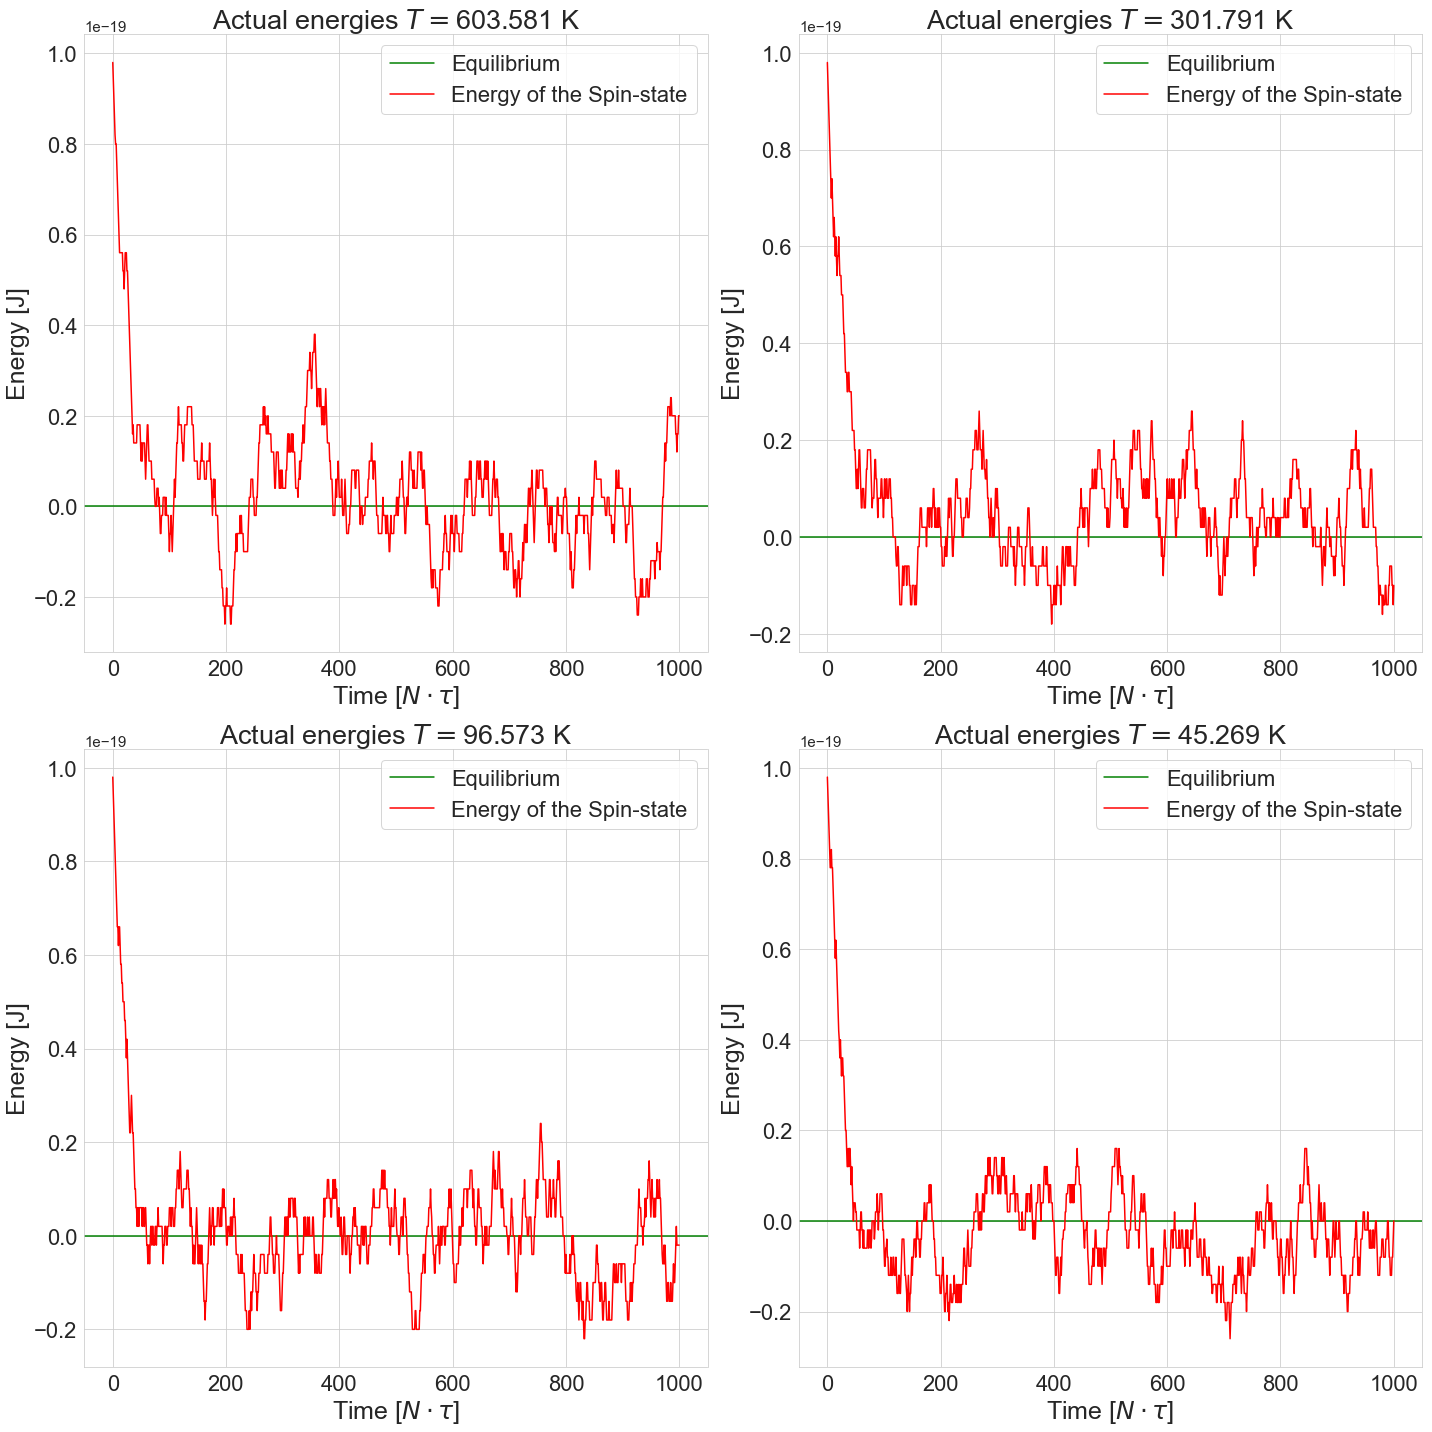

In [310]:
nrows = 2
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,20))

titlesize=27
axislabelsize=25
axisticksize=22
legendsize=22

for i in range(0,nrows):
    for j in range(0,ncols):

        axes[i][j].axhline(y=0, color='green', label='Equilibrium')
        axes[i][j].plot(step_indeces_1D, energy_chronology_1D[str(i*nrows + j + 1)], c='red', label='Energy of the Spin-state')

        axes[i][j].set_title('Actual energies $T =${0:.3f} K'.format(1 / (betas[str(i*nrows + j + 1)] * k_B)), fontsize=titlesize)

        axes[i][j].set_xlabel('Time [$N \\cdot \\tau$]', fontsize=axislabelsize)
        axes[i][j].set_ylabel('Energy [J]', fontsize=axislabelsize)

        axes[i][j].tick_params(axis='both', which='major', labelsize=axisticksize)
        axes[i][j].yaxis.get_offset_text().set_fontsize(15)

        axes[i][j].legend(loc='upper right', fontsize=legendsize)
        
fig.tight_layout()
plt.savefig('discrete_energies_1D.' +
            image_format,
            format=image_format,
            dpi=image_dpi,
            bbox_inches='tight')
plt.show()

# Ising model simulation on 2D lattice

## 1.: Randomly choose directions for starting position of the spins

In [88]:
def choose_sign_2D():
    return -1 if random.random() < 0.5 else 1

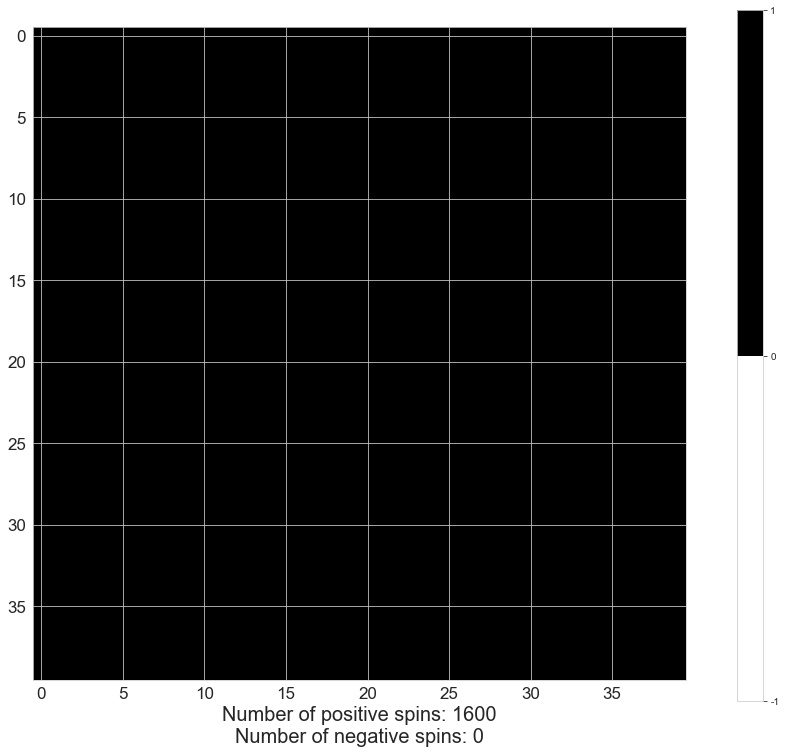

In [352]:
# The current positions of the spins
#Spins_2D = np.array(([[choose_sign() for i in range(0, N_spin_2D)] for i in range(0, N_spin_2D)]))
Spins_2D = np.ones((N_spin_2D, N_spin_2D))
Spins_positive_2D = Spins_2D[Spins_2D>0]
Spins_negative_2D = Spins_2D[Spins_2D<0]

figsize= 12
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(figsize,figsize))

scattersize = 10
axislabelsize = 20
axisticksize = 17
legendsize = 17

spin_image = axes.imshow(Spins_2D, cmap='Greys_r')

axes.set_xlabel('Number of positive spins: {0}\nNumber of negative spins: {1}'.format(len(Spins_positive_2D),
                                                                                      len(Spins_negative_2D)),
                fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)

#
#  CUSTOM COLORBAR
#
cmap = plt.cm.Greys  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(-1, 1, 3)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# create a second axes for the colorbar
ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
     spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')

plt.show()

## 2.1.: $E_{tot.}$ energy of the current state

In [312]:
def E_Initial_2D(Spins):
    
    E = 0
    
    for i in range(0, N_spin_2D-2):
        for j in range(0, N_spin_2D-2):
            
            try:
                E += Spins[i][j] * Spins[i+1][j] + Spins[i][j] * Spins[i][j+1] + Spins[i][j] * Spins[i+1][j+1]
            except:
                pass
            else:
                continue
    
    return E * J

## 2.2.: $\Delta E$ energy change due to spin-flip

In [313]:
def dE_2D(Spins, indeces):
    
    E = 0
    
    for i in range(-1, 2):
        for j in range(-1, 2):
            if(i != 0 and j != 0):
                try:
                    E += 2 * Spins[indeces[0]][indeces[1]] * Spins[indeces[0]+i][indeces[1]+j]
                except:
                    pass
                else:
                    continue
                    
    return E * J

## 3.: Step with the simulation

In [353]:
def simulation_step_2D(beta, steps, Spins_2D):

    Spins = Spins_2D
    # Chronologies for reached energy levels' indeces and actual energies in order
    spin_changes_chronology = np.zeros((steps+1, N_spin_2D, N_spin_2D), dtype='int')
    energy_chronology = np.zeros((steps+1))
    
    # Starting position on X axis
    energy_chronology[0] = E_Initial_2D(Spins=Spins)

    for current_step in range(0, steps):
        # Choose a random Ising spin from the pool at the start of every step
        choosen_spin_indeces = np.random.choice([i for i in range(0, N_spin_2D)], 2)
        
        # Rotate it to check the energy difference
        New_Spins = Spins
        New_Spins[choosen_spin_indeces[0]][choosen_spin_indeces[1]] *= -1

        # Calculate energy difference between the jump's origin and end points
        E_1 = E_Initial_2D(Spins=Spins)

        E_2 = E_Initial_2D(Spins=New_Spins)
        
        delta_E = E_2 - E_1

        # Update chronology of reached energies indeces
        # If delta_E <= 0, then execute the flip
        if(delta_E < 0):
            spin_changes_chronology[current_step+1] = New_Spins
            Spins = New_Spins
            # Update chronology of actual reached energy levels
            energy_chronology[current_step+1] = E_2
            
        if(delta_E == 0):
            if(random.random() < 0.5):
                spin_changes_chronology[current_step+1] = New_Spins
                Spins = New_Spins
                # Update chronology of actual reached energy levels
                energy_chronology[current_step+1] = E_2
                
            else:
                spin_changes_chronology[current_step+1] = Spins
                # Update chronology of actual reached energy levels
                energy_chronology[current_step+1] = E_1

        # If delta_E > 0, choose a random number X, between 0 and 1
        # If X < e^(-beta * delta_E), then execute the spin flip
        # If not, then leave the spins' state untouched and continue with the next step
        else:
            if(random.random() < np.exp(- beta * delta_E)):
                spin_changes_chronology[current_step+1] = New_Spins
                Spins = New_Spins
                # Update chronology of actual reached energy levels
                energy_chronology[current_step+1] = E_2
                
            else:
                spin_changes_chronology[current_step+1] = Spins
                # Update chronology of actual reached energy levels
                energy_chronology[current_step+1] = E_1

    return spin_changes_chronology, energy_chronology, Spins

## Run the simulation with initial conditions

In [354]:
steps_2D = 10000

# Dicts for storing the energy levels' indeces and actual energies for various betas
spin_changes_chronology_2D = {}
energy_chronology_2D = {}
Spins_2D_dict = {}

# Run the simulation
for i in range(0,len(betas)):
    (spin_changes_chronology_2D[str(i+1)],
    energy_chronology_2D[str(i+1)],
    Spins_2D_dict[str(i+1)]) = simulation_step_2D(beta=betas[str(i+1)],
                                                  steps=steps_2D,
                                                  Spins_2D=Spins_2D.copy())

step_indeces_2D = np.asarray([i for i in range(0, steps_2D+1)])

## Final spin-state

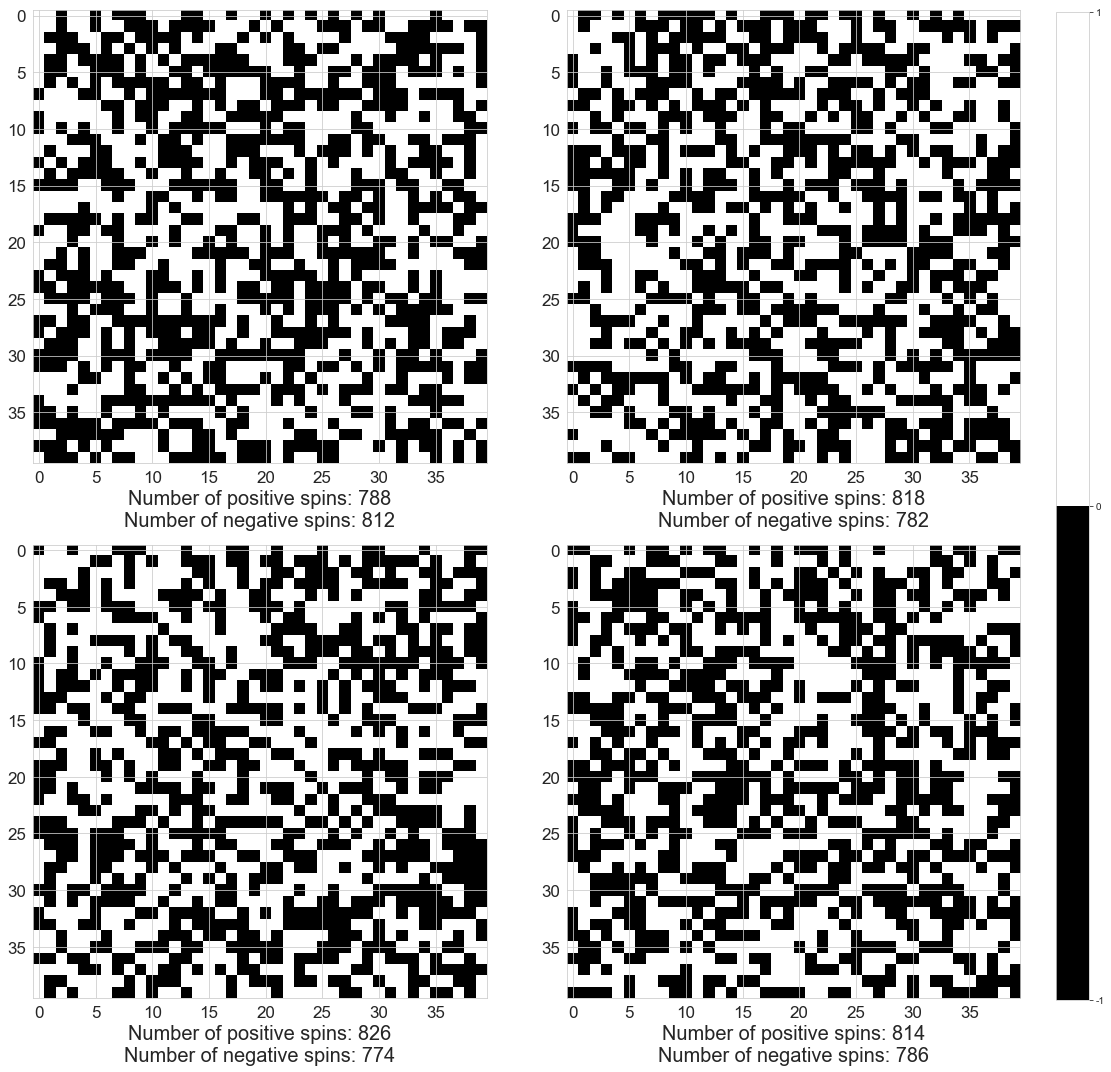

In [355]:
figsize= 15
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(figsize,figsize))

scattersize = 10
axislabelsize = 20
axisticksize = 17
legendsize = 17

for i in range(0, nrows):
    for j in range(0, ncols):
        
        spin_image = axes[i][j].imshow(Spins_2D_dict[str(i*ncols + j + 1)], cmap='Greys_r')
        
        # The current positions of the spins
        Spins_positive_2D = Spins_2D_dict[str(i*ncols + j + 1)][Spins_2D_dict[str(i*nrows + j + 1)]>0]
        Spins_negative_2D = Spins_2D_dict[str(i*ncols + j + 1)][Spins_2D_dict[str(i*nrows + j + 1)]<0]
        
        axes[i][j].set_xlabel('Number of positive spins: {0}\nNumber of negative spins: {1}'.format(len(Spins_positive_2D),
                                                                                                    len(Spins_negative_2D)),
                        fontsize=axislabelsize)
        axes[i][j].tick_params(axis='both', which='major', labelsize=axisticksize)

fig.tight_layout()

#
#  CUSTOM COLORBAR
#
cmap = plt.cm.Greys_r  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(-1, 1, 3)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# create a second axes for the colorbar
ax2 = fig.add_axes([1, 0.07, 0.03, 0.915])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
     spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')

plt.show()

In [356]:
np.save('spinstate_2D.npy', spin_changes_chronology_2D['1'])

## Energy propagation of the system

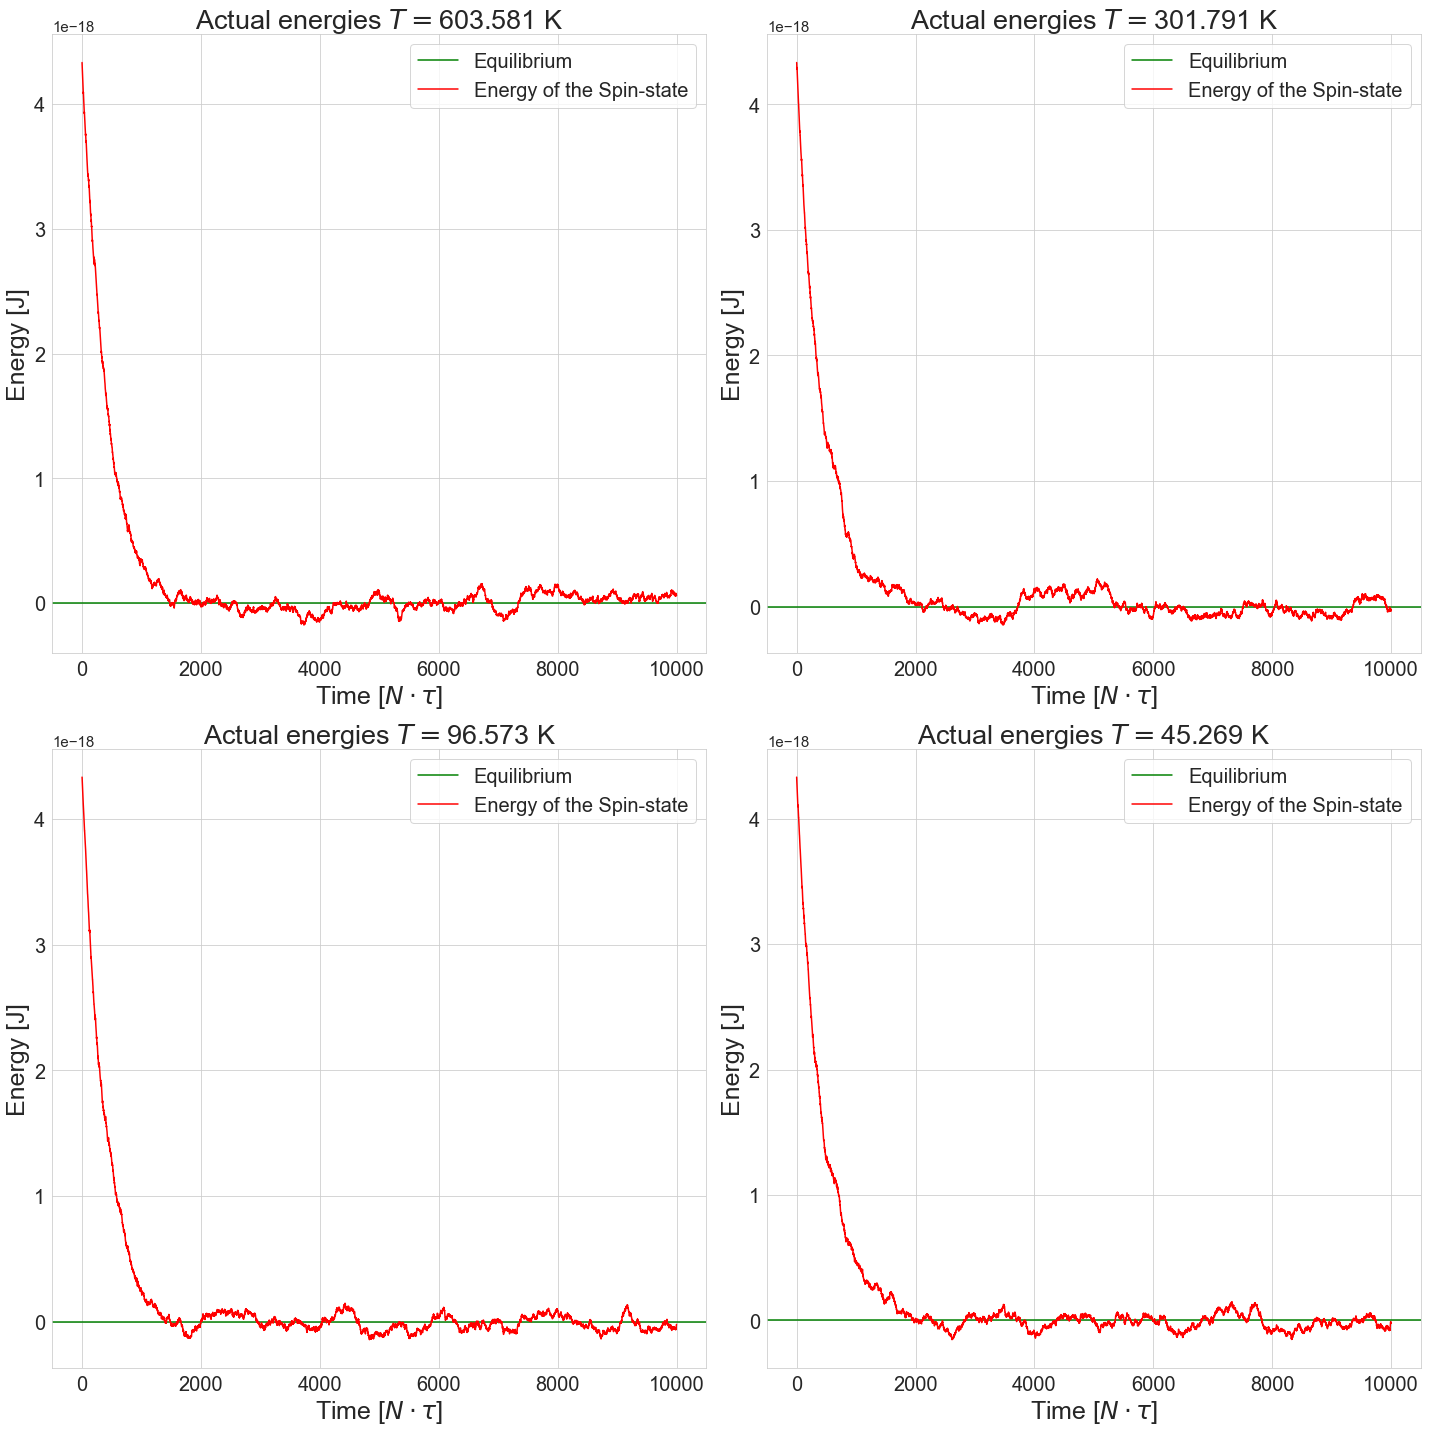

In [357]:
nrows = 2
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,20))

titlesize=27
axislabelsize=25

for i in range(0,nrows):
    for j in range(0,ncols):

        axes[i][j].axhline(y=0, color='green', label='Equilibrium')
        axes[i][j].plot(step_indeces_2D, energy_chronology_2D[str(i*nrows + j + 1)], c='red', label='Energy of the Spin-state')

        axes[i][j].set_title('Actual energies $T =${0:.3f} K'.format(1 / (betas[str(i*nrows + j + 1)] * k_B)),
                             fontsize=titlesize)

        axes[i][j].set_xlabel('Time [$N \\cdot \\tau$]', fontsize=axislabelsize)
        axes[i][j].set_ylabel('Energy [J]', fontsize=axislabelsize)

        axes[i][j].tick_params(axis='both', which='major', labelsize=20)
        axes[i][j].yaxis.get_offset_text().set_fontsize(15)

        axes[i][j].legend(loc='upper right', fontsize=20)
        
fig.tight_layout()
plt.savefig('discrete_energies_2D.' +
            image_format,
            format=image_format,
            dpi=image_dpi,
            bbox_inches='tight')
plt.show()